In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
import nltk
import re
import string
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

from nltk.stem import PorterStemmer


stop_words = stopwords.words()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Reviews.csv')
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [5]:
# Check for missing values
print(df.isnull().sum())

# Check the distribution of the Score column
print(df['Score'].value_counts())


Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64
Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64


In [6]:
# Filter out neutral scores (Score 3)
df = df[df['Score'] != 3]

# Map Score 1 and 2 to 0 (negative), and Score 4 and 5 to 1 (positive)
df['sentiment'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

# Drop unnecessary columns
df = df.drop(columns=['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time'])


<ipython-input-6-f652439d010f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)


In [8]:
df['text'] = df['Summary'] + ' ' + df['Text']
df

,Summary,Text,sentiment,text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,Good Quality Dog Food I have bought several of...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,Not as Advertised Product arrived labeled as J...
2,"""Delight"" says it all",This is a confection that has been around a fe...,1,"""Delight"" says it all This is a confection tha..."
3,Cough Medicine,If you are looking for the secret ingredient i...,0,Cough Medicine If you are looking for the secr...
4,Great taffy,Great taffy at a great price. There was a wid...,1,Great taffy Great taffy at a great price. The...
...,...,...,...,...
568449,Will not do without,Great for sesame chicken..this is a good if no...,1,Will not do without Great for sesame chicken.....
568450,disappointed,I'm disappointed with the flavor. The chocolat...,0,disappointed I'm disappointed with the flavor....
568451,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",1,Perfect for our maltipoo These stars are small...
568452,Favorite Training and reward treat,These are the BEST treats for training and rew...,1,Favorite Training and reward treat These are t...


In [9]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

<Axes: >

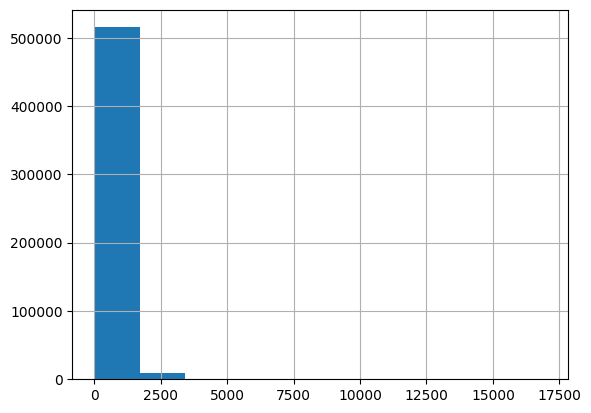

In [11]:
df['text'].str.len().hist()

Text(0.5, 1.0, 'The Negative Value')

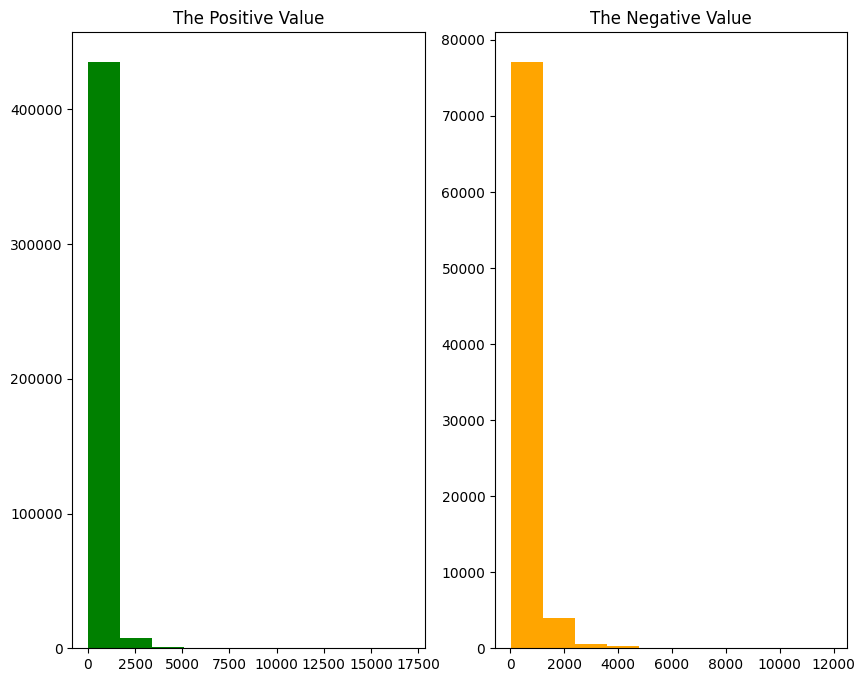

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,8))
ax1.hist(df[df['sentiment']==1]['text'].str.len(),color='green')
ax1.set_title( 'The Positive Value')
ax2.hist(df[df['sentiment']==0]['text'].str.len(),color='orange')
ax2.set_title( 'The Negative Value')

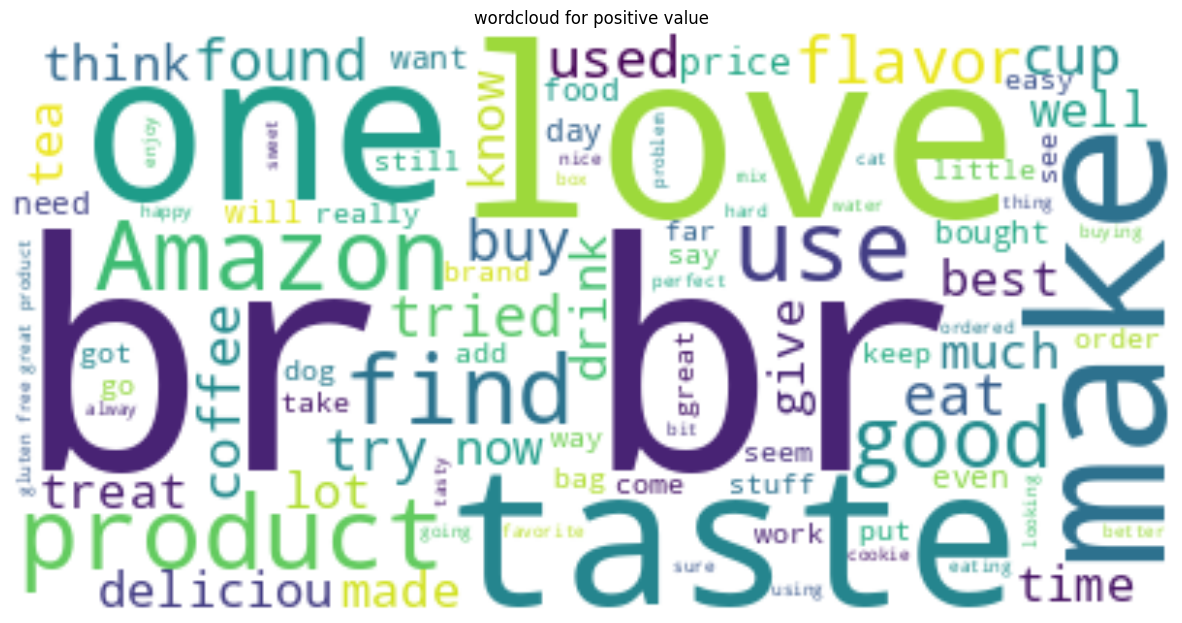

In [16]:
text = " ".join(i for i in df[df['sentiment']==1]['text'])
wordcloud = WordCloud( background_color="white").generate(text)

plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('wordcloud for positive value')
plt.show()

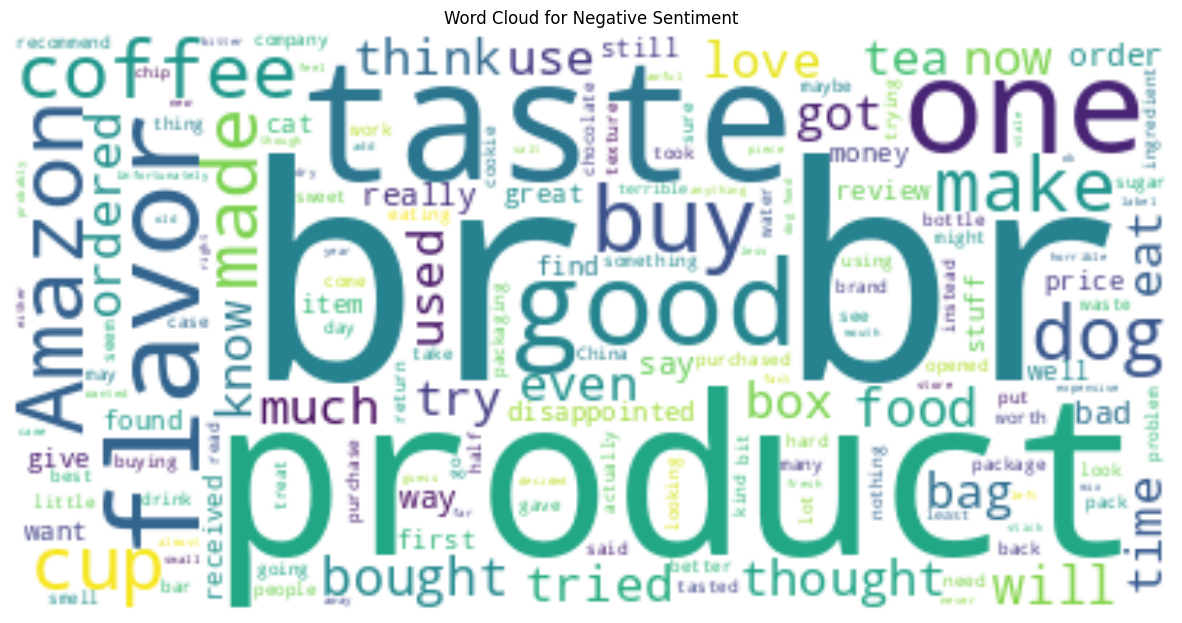

In [20]:
# Fill NaN values in the 'text' column with an empty string
df['text'] = df['text'].fillna('')

# Now generate the word cloud for negative sentiment (sentiment == 0)
text = " ".join(i for i in df[df['sentiment'] == 0]['text'])

# Generate the word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color="white").generate(text)

# Plot the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Negative Sentiment')
plt.show()


In [21]:
cnt = Counter()
for text in df["text"].values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common(10)
temp = pd.DataFrame(cnt.most_common(10))
temp.columns=['word', 'count']
temp

,word,count
0,the,1501943
1,I,1278878
2,and,1169452
3,a,1082637
4,to,921161
5,of,732127
6,is,668211
7,it,581286
8,for,510517
9,in,481240


In [22]:
px.bar(temp, x="count", y="word", title='Commmon Words in Text', orientation='h',
             width=700, height=700)

In [23]:
x=df['text'].values
y=df['sentiment'].values


#TF-IDF vectors
word_vector=TfidfVectorizer()
x=word_vector.fit_transform(x)

In [24]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [25]:
# Train the model
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [26]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions
y_pred = model.predict(x_test)

# Evaluate our model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy: 0.9513992563924574
              precision    recall  f1-score   support

           0       0.89      0.78      0.83     16379
           1       0.96      0.98      0.97     88784

    accuracy                           0.95    105163
   macro avg       0.93      0.88      0.90    105163
weighted avg       0.95      0.95      0.95    105163



In [27]:
CNB = ComplementNB()
CNB.fit(x_train, y_train)

ComplementNB()

In [28]:
from sklearn import metrics
predicted = CNB.predict(x_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('ComplementNB model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))

ComplementNB model accuracy is 91.78%
------------------------------------------------
Confusion Matrix:
       0      1
0  10661   5718
1   2924  85860
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.65      0.71     16379
           1       0.94      0.97      0.95     88784

    accuracy                           0.92    105163
   macro avg       0.86      0.81      0.83    105163
weighted avg       0.91      0.92      0.91    105163



In [29]:
from sklearn.naive_bayes import MultinomialNB

MNB = MultinomialNB()
MNB.fit(x_train, y_train)

MultinomialNB()

In [30]:
predicted = MNB.predict(x_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('MultinominalNB model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))

MultinominalNB model accuracy is 86.90%
------------------------------------------------
Confusion Matrix:
      0      1
0  2781  13598
1   178  88606
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.17      0.29     16379
           1       0.87      1.00      0.93     88784

    accuracy                           0.87    105163
   macro avg       0.90      0.58      0.61    105163
weighted avg       0.88      0.87      0.83    105163

